In [2]:
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt

from edatools import correlational_matrix_heatmap, correlation_bar_graph
CLEAN_DATA_DIR = "../data/clean"

# Checking for Multicolinearity

### Correlation Matrix: HouseholdInfo

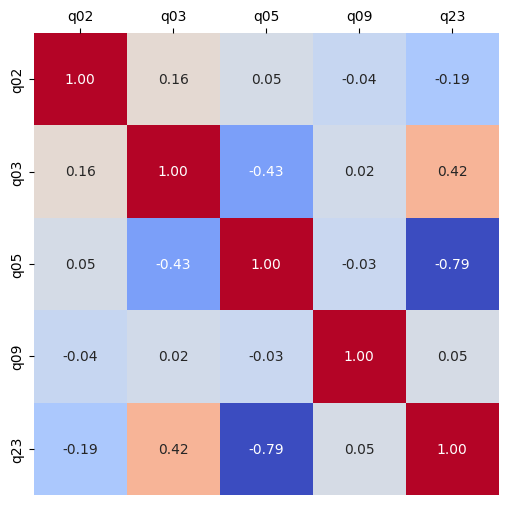

In [3]:
house_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_HouseholdInfo_clean.csv"))
correlational_matrix_heatmap(house_train, cols_to_exclude=['psu_hh_idcode', 'hhid'])

### Observations:
1. q17 and q11 are pretty highly correlated (0.88) shoudl we get rid of either one?
  
     - q11(1 if mom is living in the household, 0 otherwise)
     - q17(1 if dad is living in the household, 0 otherwise)

      > we decided to combine the two to create a new column q23 such that:
            q23 ( 0 if neither mom,dad live in household, 1 if one of them, 2 if both)


2. q10 has undefined variance.
   - reason: q10 only takes value 1 for all rows, so no variance. 0 variance means undefined correlation with any other variate.
   - because Correlation r between two variates X and Y:
  
    $$
      r = \frac{Cov(X,Y)}{\sigma_X \sigma_Y}
$$

      > we decided to get rid of this column

3. >Our threshold for high correlation was >0.8. 

### Correlational Matrix: Educataion

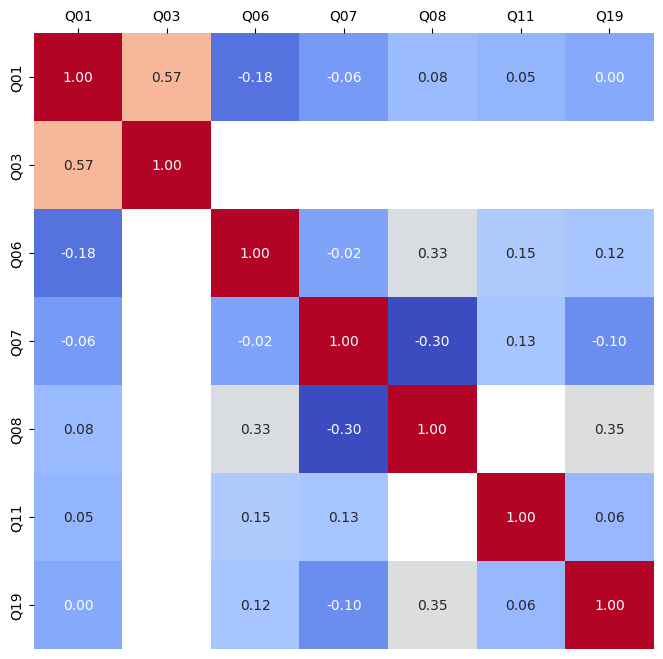

In [53]:
edu_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_Education_clean.csv"))
correlational_matrix_heatmap(edu_train, fig_size=(8,8), cols_to_exclude=['psu_hh_idcode'])

### Observations:
- We cant calculate correlation between Q3 and subsequent variates because Q4,Q5,etc... only have responses when Q3 == 1. This means that Q3 has variance 0 which gives an undefined correlation. 
- same for undefined correlation with Q8 and Q11, since Q11 only has a response when Q8 is "NO". 
- Q1 and Q2 have high correlation (0.88) => keep Q1
- Q4 and Q6 have high correlation (0.87)
- Q4 and Q5 : 버려 
- Q18 날려
- Q17 날려 (11이랑 넘 비슷함)
- Q14 날려 (8이랑 비슷함)
- cols to keep:

# Correlation Analysis: explanatory variates to ratings

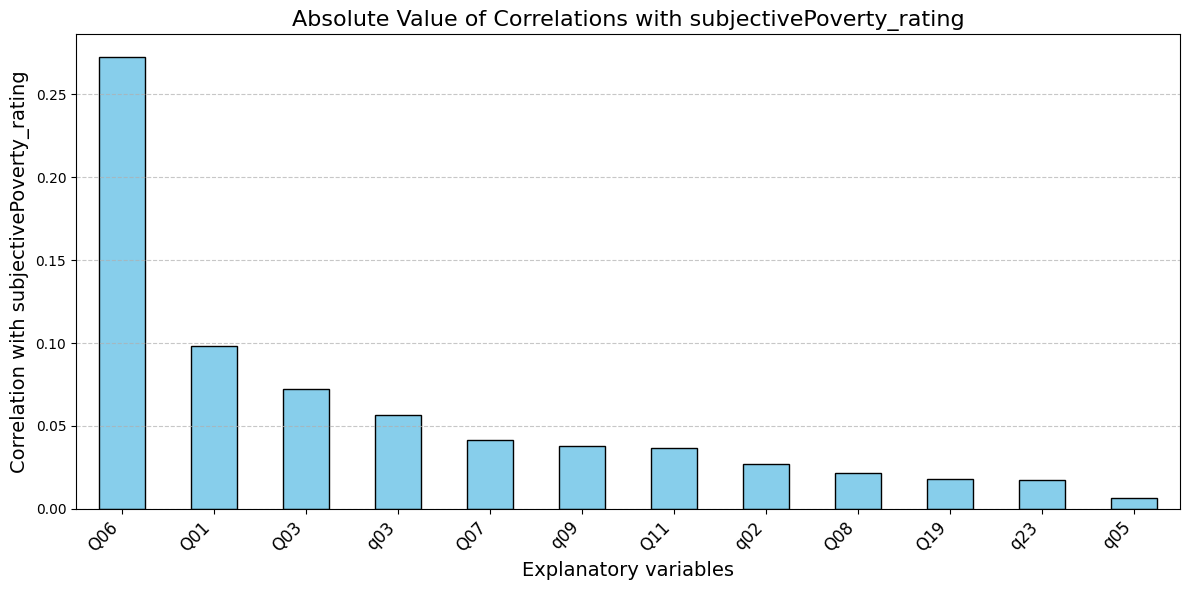

In [13]:
house_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_HouseholdInfo_clean.csv"))
edu_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_Education_clean.csv"))
ratings_train = pd.read_csv(os.path.join(CLEAN_DATA_DIR, "train_SubjectivePoverty_clean.csv"))

merged_train_inner = ratings_train.merge(house_train, on='psu_hh_idcode', how='inner').merge(edu_train, on='psu_hh_idcode', how='inner')
cols = ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating'] + [col for col in merged_train_inner.columns if col not in ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating']]
merged_train_inner = merged_train_inner[cols]
merged_train_inner.to_csv(os.path.join(CLEAN_DATA_DIR, "TRAIN_MERGED_UNFILLED.csv"), index=False)
correlation_bar_graph(merged_train_inner, fig_size=(12,6), y_col='subjectivePoverty_rating', x_cols_to_exclude=['hhid', 'psu_hh_idcode'])

In [6]:
# Train/Validation Split: is this required?



Series([], Name: subjectivePoverty_rating, dtype: float64)


We generated a graph for correlations with the ratings for each explanatory variable. The chart graphs absolute value of the correlation, just to see the strength of relationship with our y variate. 

Q06: 최종학력 has the highest absolute correlation with the rating of about 0.27.

Combining the datasets with label, filling in missing ratings by:
- assuming members without ratings have the same ratings as another member from the same household

### Create train dataset

In [14]:
# Filling in missing subjectiveRating labels with the assumption "same household => same rating" 
merged_train_outer = ratings_train[['psu_hh_idcode', 'subjectivePoverty_rating']].merge(house_train, on='psu_hh_idcode', how='outer').merge(edu_train, on='psu_hh_idcode', how='outer')
cols = ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating'] + [col for col in merged_train_outer.columns if col not in ['psu_hh_idcode', 'hhid', 'subjectivePoverty_rating']]
merged_train_outer = merged_train_outer[cols] # data frame containing all rows

ratings_by_household = merged_train_inner[['hhid', 'subjectivePoverty_rating']]
ratings_by_household = ratings_by_household.rename(columns={'subjectivePoverty_rating': 'hh_rating'})

ratings_by_household.head()
merged_train_outer = merged_train_outer.merge(ratings_by_household, on='hhid', how='left') # keep hh_rating as rating
merged_train_outer.drop(columns=['subjectivePoverty_rating'], inplace=True)
merged_train_outer = merged_train_outer.rename(columns={'hh_rating': 'rating_filled'})

# reorder cols
cols = ['psu_hh_idcode', 'hhid', 'rating_filled'] + [col for col in merged_train_outer.columns if col not in ['psu_hh_idcode', 'hhid', 'rating_filled']]
merged_train_outer = merged_train_outer[cols]

print("Total Rows in merged_train_outer: ", len(merged_train_outer))
display(merged_train_outer.isna().mean().to_frame(name="NA Rate"))

# drop rows with missing ratings now (15% of all rows)
merged_train_outer = merged_train_outer[merged_train_outer['rating_filled'].notna()]
print("Total Rows in merged_train_outer: ", len(merged_train_outer))
display(merged_train_outer.isna().mean().to_frame(name="NA Rate"))

# OUTPUT TO CSV
merged_train_outer.to_csv(os.path.join(CLEAN_DATA_DIR, "TRAIN_MERGED_FILLED.csv"), index=False)

Total Rows in merged_train_outer:  24001


,NA Rate
psu_hh_idcode,0.000000
hhid,0.000000
rating_filled,0.155744
q02,0.000000
q03,0.000000
q05,0.000000
q09,0.000000
q23,0.000000
Q01,0.066456
Q03,0.066456


Total Rows in merged_train_outer:  20263


,NA Rate
psu_hh_idcode,0.000000
hhid,0.000000
rating_filled,0.000000
q02,0.000000
q03,0.000000
q05,0.000000
q09,0.000000
q23,0.000000
Q01,0.064601
Q03,0.064601


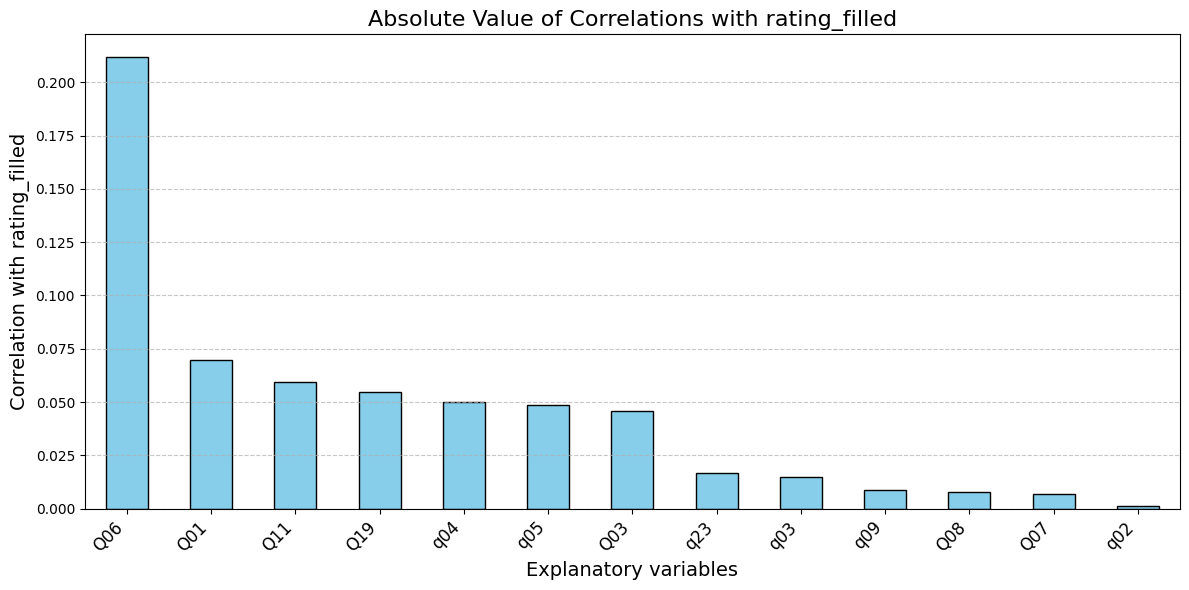

In [5]:
correlation_bar_graph(merged_train_outer, fig_size=(12,6), y_col='rating_filled', x_cols_to_exclude=['hhid', 'psu_hh_idcode'])